In [ ]:
!pip install -q datasets
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 42.3 MB/s eta 0:00:00


#Import data from google drive

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_ids = ["1yWbvg1gVbSYvlFXahJkeBjHtfNAfwfJG", 
            "1mxU7-H1ROaobkQ8cWqWBSewldisriUfk",
            "1UjTKjVR4WcsPJzVdNYsdzDGl5wpDoPVE"] # We will get these ids from Balancing_Dataset.ipynb


for id in range(len(file_ids)):
  downloaded = drive.CreateFile({'id': file_ids[id]})
  if id == 0:
    downloaded.GetContentFile('/content/train_balanced.csv')  
  if id == 1:
    downloaded.GetContentFile('/content/val_balanced.csv')  
  if id == 2:
    downloaded.GetContentFile('/content/test_balanced.csv')  

# See Data

In [ ]:
import pandas as pd
#Display all column
pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv('train_balanced.csv', sep=',')
df_train = pd.DataFrame(data)
df_train.groupby('label').size()

label
0    6416
1    5410
2    6416
dtype: int64

In [ ]:
data = pd.read_csv('val_balanced.csv', sep=',')
df_val = pd.DataFrame(data)
df_val.groupby('label').size()

label
0    735
1    735
2    735
dtype: int64

In [ ]:
data = pd.read_csv('test_balanced.csv', sep=',')
df_test = pd.DataFrame(data)
df_test.groupby('label').size()

label
0    208
1     88
2    204
dtype: int64

### Merge Dataset

In [ ]:
#Merge the training, validation, and test data
merged = pd.concat([df_train, df_val, df_test])
merged.shape

(20947, 3)

In [ ]:
#Split the data

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(merged, train_size=0.75, stratify=merged['label'])
df_val, df_test = train_test_split(df_val, test_size=0.5, stratify=df_val['label'])

print("{}, {}, {}".format(df_train.shape, df_val.shape, df_test.shape))

(15710, 3), (2618, 3), (2619, 3)


In [ ]:
df_train

,text,label,text_clean
1771,serius free ong aku di jember soalnya,1,serius free ong aku di jember soal
12752,Selamat siang wargauroboyo Beberapa waktu yang...,1,selamat siang wargauroboyo beberapa waktu yang...
1355,restoran yang menyajikan hidangan akulturasi b...,0,restoran yang saji hidang akulturasi belanda d...
13922,2nd giveaway aku mau adain giveaway dalam rang...,1,2nd giveaway aku mau adain giveaway dalam rang...
5083,bu susi karena pengalaman usaha perikanan jadi...,0,bu sus karena alam usaha ikan jadi tahu masala...
...,...,...,...
10244,"padahal baru beli paket 9 gb dan masih 3 gb , ...",2,padahal baru beli paket 9 gb dan masih 3 gb ko...
6236,terima kasih pak untuk kinerja bapak yang begi...,0,terima kasih pak untuk kerja bapak yang begitu...
1689,ini kamu dom mana,1,ini kamu dom mana
10114,amin . salut buat para dokter yang telah membe...,0,amin salut buat para dokter yang telah beri ba...


# NNLM Transfer Learning

In [ ]:
import numpy as np

In [ ]:
#Fill the missing value

x_train = df_train['text_clean']
# x_train = df_train['text']
y_train = df_train['label']

# x_val = df_val['text_clean']
x_val = df_val['text']
y_val = df_val['label']

# x_test = df_test['text_clean']
x_test = df_test['text']
y_test = df_test['label']

x_train.fillna(value='', inplace=True)
x_val.fillna(value='', inplace=True)
x_test.fillna(value='', inplace=True)

In [ ]:
#See the datatrain shape
(x_train.shape, y_train.shape)

((15710,), (15710,))

In [ ]:
batch_size = 64

In [ ]:
import tensorflow as tf

#Even up the data length

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .shuffle(1000)
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    # .shuffle(1000)
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

In [ ]:
#See Dataset Length

for i,x in enumerate(train_dataset):
  print("x[0].ndim: ", x[0].ndim)
  print("x[0].shape: ", x[0].shape)
  print("x[1].shape: ", x[1].shape)
  if i==0:
    break

for i,x in enumerate(test_dataset):
  print("x[0].ndim: ", x[0].ndim)
  print("x[0].shape: ", x[0].shape)
  print("x[1].shape: ", x[1].shape)
  if i==0:
    break


x[0].ndim:  1
x[0].shape:  (64,)
x[1].shape:  (64,)
x[0].ndim:  1
x[0].shape:  (64,)
x[1].shape:  (64,)


In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers

In [ ]:
#Call the NNLM model
nnlm = "https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(nnlm, input_shape=[],dtype=tf.string, trainable=True)

# Model Building

In [ ]:
#Create the model
model = Sequential([
    hub_layer,
    layers.Dropout(0.5),
    layers.Dense(128),
    layers.Dropout(0.5),
    layers.Dense(128),
    layers.Dropout(0.5),
    layers.Dense(32),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax'),
])
model.compile(optimizer=tf.optimizers.Adam(),loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4

In [ ]:
history = model.fit(train_dataset, epochs=10,validation_data=(val_dataset), callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

Epoch 1/10
246/246 [==============================] - 45s 149ms/step - loss: 0.7826 - accuracy: 0.6480 - val_loss: 0.5176 - val_accuracy: 0.7922
Epoch 2/10
246/246 [==============================] - 16s 64ms/step - loss: 0.5331 - accuracy: 0.7875 - val_loss: 0.4767 - val_accuracy: 0.8052
Epoch 3/10
246/246 [==============================] - 13s 53ms/step - loss: 0.4244 - accuracy: 0.8376 - val_loss: 0.4956 - val_accuracy: 0.7960
Epoch 4/10
246/246 [==============================] - 12s 51ms/step - loss: 0.3526 - accuracy: 0.8691 - val_loss: 0.5139 - val_accuracy: 0.7991


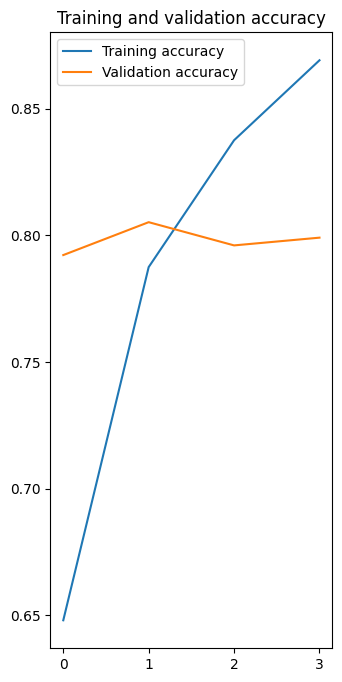

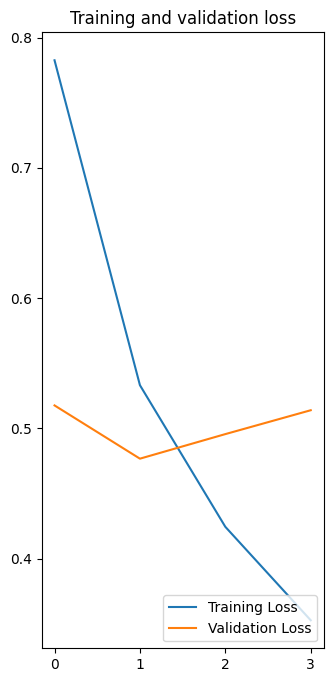

In [ ]:
#Visualize the Training & Validation's Accuracy and Loss

import matplotlib.pyplot as plt

def plot_loss_acc(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, label='Validation accuracy')
  plt.legend(loc='upper left')
  plt.title('Training and validation accuracy')

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='lower right')
  plt.title('Training and validation loss')
 
  plt.show()
# Plot training results
plot_loss_acc(history)
     

In [ ]:
#Accuracy test
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('Model accuracy: ',test_acc)

41/41 - 0s - loss: 0.4596 - accuracy: 0.8209 - 259ms/epoch - 6ms/step
Model accuracy:  0.8209240436553955


In [ ]:
sentiment = ['Positive','Neutral','Negative']

In [ ]:
#Sentiment Prediction Test
sequence = ['kerjanya bagus tapi lama banget bikin kesel']
sentiment[model.predict(sequence).argmax(axis=1)[0]]

1/1 [==============================] - 0s 194ms/step


'Negative'

In [ ]:
predictions = model.predict(test_dataset)

41/41 [==============================] - 0s 6ms/step


Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.around(predictions, decimals=0).argmax(axis=1), target_names=['Positive', 'Neutral', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.87      0.93      0.90       920
     Neutral       0.79      0.76      0.78       779
    Negative       0.77      0.75      0.76       920

    accuracy                           0.82      2619
   macro avg       0.81      0.81      0.81      2619
weighted avg       0.81      0.82      0.81      2619



Confusion Matrix

<ipython-input-29-ed286f56bf55>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


Text(0.5, 23.52222222222222, 'Prediction')

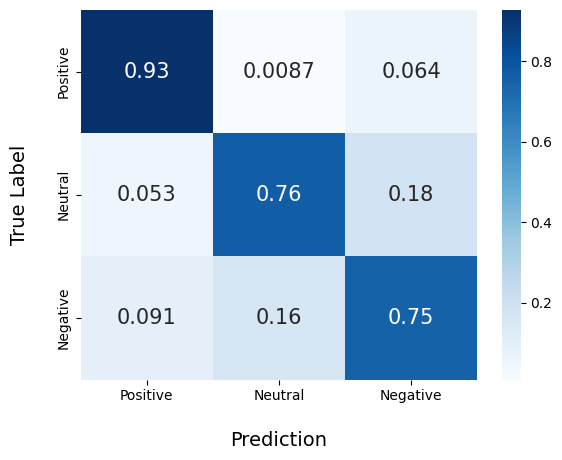

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

matrix = confusion_matrix(y_test, np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Positive','Neutral','Negative'],columns = ['Positive','Neutral','Negative'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15}, cmap='Blues')
ax.set_ylabel("True Label", fontsize=14, labelpad=20)
ax.set_xlabel("Prediction", fontsize=14, labelpad=20)


Saving Model

In [ ]:
#Save model in Hierarchical Data Format 5 File.

model.save("nlp_model.h5")
model.save("nlp_model")

!zip -r /content/nlp_model.zip /content/nlp_model.h5

  adding: content/nlp_model.h5 (deflated 68%)


In [ ]:
from google.colab import files
files.download("nlp_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import the required libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Define the file ID and destination path
file_id = "1yWbvg1gVbSYvlFXahJkeBjHtfNAfwfJG"
destination_path = "/content/nlp_model.h5"

# Download the file from Google Drive
downloaded_file = drive.CreateFile({'id': file_id})
downloaded_file.GetContentFile(destination_path)

# Print a success message
print("Model file saved to Google Drive.")


Model file saved to Google Drive.


In [ ]:
import os

# Check if the file exists in the destination path
if os.path.isfile(destination_path):
    print("File saved successfully.")
else:
    print("File download failed.")

File saved successfully.
